In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import glob 
import re
from tkinter import E
csv_files = glob.glob('C:/Users/pablo/Desktop/scripts tfg/archivos min/*.min')

# Create an empty dataframe to store the combined data
combined_df_min = pd.DataFrame()
ind=['min HFB','min PNP','min PNPAMP']
combined_df_min.index=ind
E_HFB=[]
E_PNP = []
E_PNPAMP=[]
list_zn=[]
# Loop through each CSV file and append its contents to the combined dataframe
for csv_file in csv_files:
    df = pd.read_csv(csv_file,sep=' ',header=None)
    df.columns=['beta_2','E HFB','E PNP', 'E PNPAMP']
    zn=[int(s) for s in re.findall(r'\d+', csv_file)] 
    list_zn.append(zn)
    E_HFB.append(np.abs(df.iloc[0,1]))
    E_PNP.append(np.abs(df.iloc[1,2]))
    E_PNPAMP.append(np.abs(df.iloc[2,3]))


In [3]:
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyModel, self).__init__()
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(input_dim, 1000)
        self.fc2 = nn.Linear(1000, 750) 
        self.fc3 = nn.Linear(750,600)
        self.fc4 = nn.Linear (600, 800)
        self.fc5 = nn.Linear(800, output_dim)
        self.internal = nn.LeakyReLU()
        self.activation = nn.ReLU()
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)        
        self.batchnorm1=nn.BatchNorm1d(1000, eps=1e-05, momentum=None)#batch norm should be frozen when evaluating the model
        self.batchnorm2=nn.BatchNorm1d(750, eps=1e-05, momentum=None)
        self.batchnorm3=nn.BatchNorm1d(600, eps=1e-05, momentum=None)
        self.batchnorm4=nn.BatchNorm1d(800, eps=1e-05, momentum=None)

    def forward(self, x):
        x1 = self.internal(self.fc1(x))
        x1= self.batchnorm1(x1)
        x1= self.dropout(x1)
        x2 = self.internal(self.fc2(x1))
        x2=self.batchnorm2(x2)
        x2= self.dropout(x2)
        x3 = self.internal(self.fc3(x2))
        x3=self.batchnorm3(x3)
        x3= self.dropout(x3)
        x4 = self.internal(self.fc4(x3))
        x4=self.batchnorm4(x4)
        x4= self.dropout(x4)
        y=self.activation(self.fc5(x4))
        return y 


In [4]:
list_zn_E=[]
i=0
for z, n in list_zn: 
    #list_zn_E.append(n)
    #list_zn_E.append(z)
    list_zn_E.append([z,n, E_PNP[i]])
    i+=1

print(list_zn_E)


[[10, 8, 134.22240671], [10, 10, 157.51693817], [10, 12, 176.43220478], [10, 14, 189.96016403], [10, 16, 200.0997145], [10, 18, 206.43440034], [10, 20, 210.01424043], [10, 22, 210.70036867], [10, 24, 210.43124747], [12, 8, 136.75434158], [12, 10, 167.51548563], [12, 12, 193.96694469], [12, 14, 213.38408873], [12, 16, 228.96886382], [12, 18, 240.25878045], [12, 20, 248.29141295], [12, 22, 253.56405412], [12, 24, 258.14103277], [12, 26, 259.66053603], [12, 28, 259.63934214], [14, 10, 171.40566541], [14, 12, 203.51625983], [14, 14, 233.15506352], [14, 16, 252.70307765], [14, 18, 269.07597893], [14, 20, 282.18347884], [14, 22, 289.84586867], [14, 24, 297.88788722], [14, 26, 303.64801601], [14, 28, 308.95765016], [14, 30, 310.1459981], [14, 32, 310.29319174], [14, 34, 308.52985073], [16, 10, 170.68904812], [16, 12, 208.40838771], [16, 14, 240.98672399], [16, 16, 267.50761171], [16, 18, 289.2709904], [16, 20, 307.63920503], [16, 22, 319.6091043], [16, 24, 331.80176389], [16, 26, 341.77625176

In [5]:
x=torch.tensor(list_zn_E).float()
y=torch.tensor(E_PNPAMP).float()


In [6]:
from torch.utils.data import TensorDataset, DataLoader

def create_dataloaders(x, y, split_ratio):
    dataset = TensorDataset(x, y)

    train_size = int(len(dataset) * split_ratio)
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset,batch_size=train_size, shuffle=True)
    test_loader = DataLoader(test_dataset,batch_size=test_size, shuffle=False)

    return train_loader, test_loader

In [7]:
def training_model(data_size, learning_rate, x, y): 
    train_loader, test_loader = create_dataloaders(x,y,split_ratio=data_size)
    net_slice=MyModel(3,1)
    net_slice=net_slice.float()
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(net_slice.parameters(), lr=learning_rate)
    #start_time=time.time()        
    dloss=1
    loss_item=[]
    loss_item.append(0.0)
    i=0 
    nepoch=0
    for nepochs in range(1000) :
        for x_train_slice, y_train_slice in train_loader:
            x_train_slice = x_train_slice.float()
            y_train_slice = y_train_slice.float()
            hatY_slice = net_slice.forward(x_train_slice)
            optimizer.zero_grad()
            loss_slice = criterion(hatY_slice, y_train_slice)
            loss_slice.backward()
            optimizer.step()
            # solo sobre el test    
            #acc=np.std()#loss segun tamaño entreno y test y varianza
            #entrenar sobre las propias energías
            #hablar sobre tiempos de computación
            #rel_acc=acc/y_test.mean()
            if nepoch % 100 == 0:
                loss_item.append(loss_slice.item())
                dloss=np.abs(loss_item[i+1]-loss_item[i])
                i+=1
        
            
    #elapsed_time = time.time() - start_time
    for x_test_slice, y_test_slice in test_loader:
        x_test_slice=x_test_slice.float()
        y_test_slice=y_test_slice.float()
        hatY_pred_slice=net_slice.forward(x_test_slice)
        hatY_detach_slice=hatY_pred_slice.detach()
        total_loss_slice=criterion(hatY_detach_slice,y_test_slice)
    return total_loss_slice, dloss, loss_slice, nepoch, hatY_slice, hatY_pred_slice


In [8]:
#grid search
learning_rates=np.logspace(-5,-1,5)
data_sizes=np.array([0.3,0.4,0.5,0.6,0.7,0.8])
test_loss=np.zeros((len(data_sizes), len(learning_rates)))
train_loss= np.zeros_like(test_loss)
nepochs=np.zeros_like(test_loss)
fontsize=16
for a_iter, data_size in enumerate(data_sizes):
    for b_iter, learning_rate in enumerate(learning_rates):
        total_loss_slice, dloss, loss_slice, i, hatY_slice, hatY_pred_slice=training_model(data_size=data_size, learning_rate=learning_rate, x=x, y=y)
        test_loss[a_iter,b_iter]=total_loss_slice.item()
        train_loss[a_iter, b_iter]=loss_slice.item()
        

c:\Users\pablo\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([513])) that is different to the input size (torch.Size([513, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\pablo\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1199])) that is different to the input size (torch.Size([1199, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\pablo\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([684])) that is different to the input size (torch.Size([684, 1])). This will likely lead to 

KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt

def plot_data(x,y,data, title):

    # plot results
    fontsize=12


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1.5)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('loss',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.3,.6,0.9,1.2,1.5])
    cbar.set_ticklabels(['0','0.3','0.6','0.9','1.2','1.5'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "{0:.2f}".format( data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y*100]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels([""]+y)

    ax.set_xlabel('Tasa de aprendizaje',fontsize=fontsize)
    ax.set_ylabel("Tamaño de datos de entrenamiento (%)",fontsize=fontsize)
    ax.set_title(title)

    plt.tight_layout()

    plt.show()
    

C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


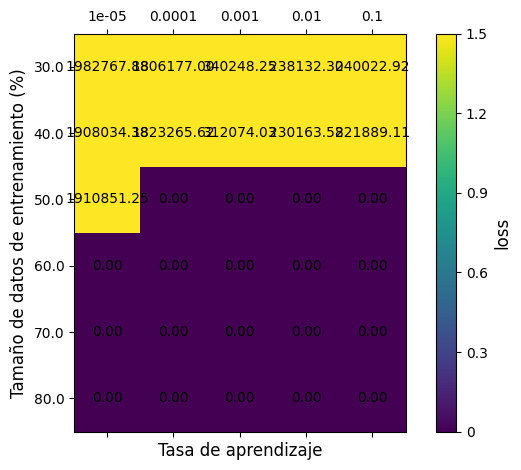

In [10]:
plot_data(learning_rates, data_sizes, train_loss, "")

C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


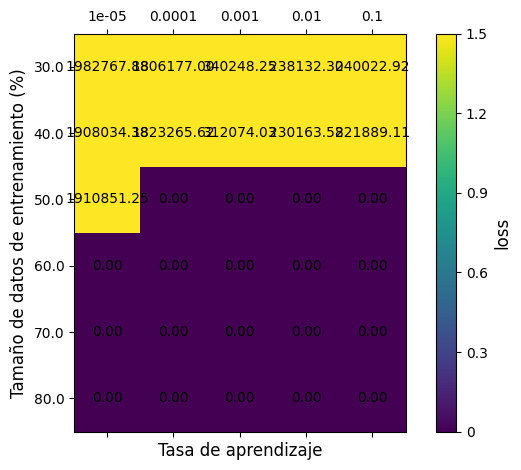

In [11]:
plot_data(learning_rates, data_sizes, train_loss, "")